In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch.utils.data as data
import numpy as np
import torch
import torch.nn as nn
import time

In [2]:
cuda_num=1

In [3]:
from dataset import select_file_with_json, make_datapath_list, DataTransform, VOCDataset
from unet_model import UNet

In [4]:
net = UNet(n_channels=3, n_classes=2)
state_dict = torch.load("./weights/Unet_init_weight_1000_1000.pth",map_location={'cuda:'+str(cuda_num): 'cpu'})
net.load_state_dict(state_dict)
print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


In [5]:
rootpath = "../data/x3"
filenames = select_file_with_json(rootpath)
(
     _,
    _,
    _,
    _,
    test_img_list,
    test_anno_list,
) = make_datapath_list(rootpath, filenames)
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
test_dataset = VOCDataset(test_img_list, test_anno_list, phase="val", transform=DataTransform(
input_size=475, color_mean=color_mean, color_std=color_std))

In [6]:
def show_detection(test_img_list,test_anno_list,test_dataset):
    """
    推論結果を表示する関数（緑:tp,赤:fp,青:fn）
    
    input:
        test_img_list
        test_anno_list
        test_dataset
    """
    time_all=0
    for index in range(len(test_img_list)):
        image_file_path = test_img_list[index]
        img_original = Image.open(image_file_path).convert(mode="RGB")   # [高さ][幅][色RGB]
        img_width, img_height = img_original.size
        anno_file_path = test_anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
        gt =Image.open(anno_file_path).convert('RGBA')
        p_palette = anno_class_img.getpalette()
        net.eval()
        img, anno_class_img = test_dataset.__getitem__(index)
        x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
        start = time.time()
        outputs = net(x)
        t = time.time() - start
        time_all+=t
        y = outputs
        y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
        y = np.argmax(y, axis=0)
        anno_class_img = Image.fromarray(np.uint8(y), mode="P")
        anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
        anno_class_img.putpalette(p_palette)
        anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換
        trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
        for x in range(img_width):
            for y in range(img_height):
                pixel = anno_class_img.getpixel((x, y))
                pixel_gt = gt.getpixel((x, y))
                if (pixel[0] != 0 or pixel[1] != 0 or pixel[2] != 0)and(pixel_gt[0] != 0 or pixel_gt[1] != 0 or pixel_gt[2] != 0):
                    trans_img.putpixel((x, y), (0, 255,0, 200))
                elif pixel[0] != 0 or pixel[1] != 0 or pixel[2] != 0 :
                    trans_img.putpixel((x, y), (120, 0,0, 200))
                elif pixel_gt[0] != 0 or pixel_gt[1] != 0 or pixel_gt[2] != 0:
                    trans_img.putpixel((x, y), (0, 0, 255, 200))
        result = Image.alpha_composite(img_original.convert('RGBA'), trans_img)
        plt.imshow(result)
        plt.show()
    print(time_all)

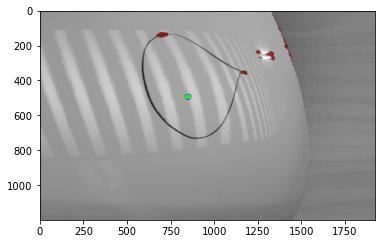

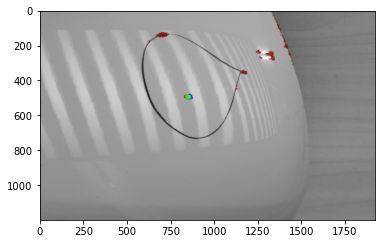

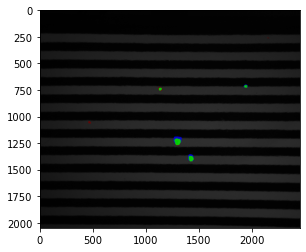

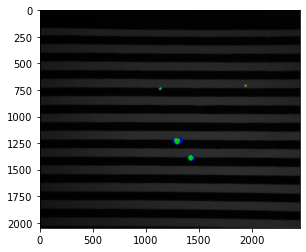

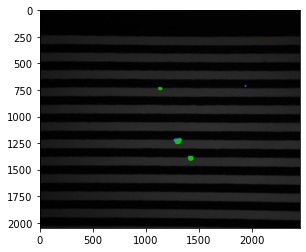

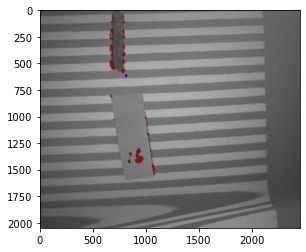

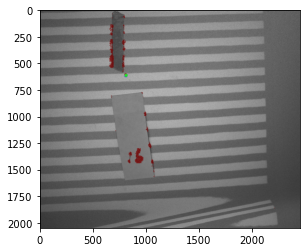

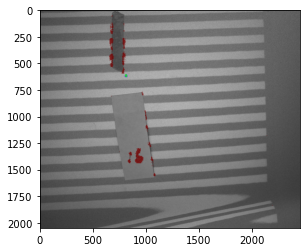

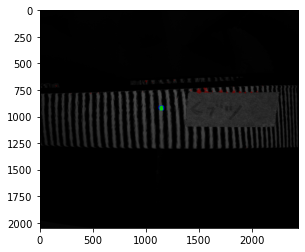

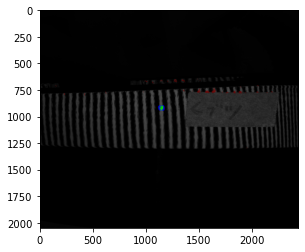

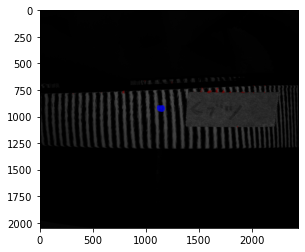

15.18376612663269


In [7]:
show_detection(test_img_list,test_anno_list,test_dataset)

In [8]:
def generate_true_pred(net,test_anno_list,test_dataset):
    """
    y_trueとy_predを出力する関数

    input: 
        anno_img:PIL.Image.Image image mode=RGB の推論データ情報のリスト
        anno_img_gt:PIL.Image.Image image mode=RGB のgtデータ情報のリスト
    return:
        y_true_list
        y_pred_list
    """
    y_true_list=[]
    y_pred_list=[]
    softmax=nn.Softmax(dim=1)
    for index,gt_path in enumerate(test_anno_list):
        gt = Image.open(gt_path)   # [高さ][幅]
        # p_palette = gt.getpalette()
        img_width, img_height = gt.size
        y_true=np.array(gt).flatten()
        y_true_list=np.hstack((y_true_list, y_true))
        img_475, _ = test_dataset.__getitem__(index)
        net.eval()
        x = img_475.unsqueeze(0)
        outputs = net(x)
        y = softmax(outputs)
        y = y[0].detach().numpy()
        y=y[1]
        detection = Image.fromarray(np.float32(y))
        detection = detection.resize((img_width, img_height), Image.NEAREST)
        print(np.array(detection))
        # detection.putpalette(p_palette)
        y_pred=np.array(detection).flatten()
        y_pred_list=np.hstack((y_pred_list,y_pred))

    return y_true_list,y_pred_list

In [9]:
y_true_list,y_pred_list=generate_true_pred(net,test_anno_list,test_dataset)

[[0.09178202 0.09178202 0.09178202 ... 0.02677364 0.02677364 0.02677364]
 [0.09178202 0.09178202 0.09178202 ... 0.02677364 0.02677364 0.02677364]
 [0.09178202 0.09178202 0.09178202 ... 0.02677364 0.02677364 0.02677364]
 ...
 [0.01747828 0.01747828 0.01747828 ... 0.00879231 0.00879231 0.00879231]
 [0.01747828 0.01747828 0.01747828 ... 0.00879231 0.00879231 0.00879231]
 [0.01747828 0.01747828 0.01747828 ... 0.00879231 0.00879231 0.00879231]]
[[0.09444924 0.09444924 0.09444924 ... 0.02546724 0.02546724 0.02546724]
 [0.09444924 0.09444924 0.09444924 ... 0.02546724 0.02546724 0.02546724]
 [0.09444924 0.09444924 0.09444924 ... 0.02546724 0.02546724 0.02546724]
 ...
 [0.01722026 0.01722026 0.01722026 ... 0.00839037 0.00839037 0.00839037]
 [0.01722026 0.01722026 0.01722026 ... 0.00839037 0.00839037 0.00839037]
 [0.01722026 0.01722026 0.01722026 ... 0.00839037 0.00839037 0.00839037]]
[[0.00714661 0.00714661 0.00714661 ... 0.00498793 0.00498793 0.00498793]
 [0.00714661 0.00714661 0.00714661 ... 

[8.67255786e-04 8.66872743e-04 8.66873180e-04 ... 5.00000000e-01
 0.00000000e+00 1.00000000e+00]
[1.00000000e+00 9.99557924e-01 9.99557924e-01 ... 1.86137416e-04
 0.00000000e+00 0.00000000e+00]
[1.79893817e-04 1.79922456e-04 1.80112635e-04 ... 9.99816954e-01
 9.99838769e-01 9.99928951e-01]


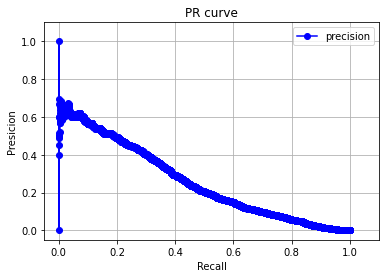

auc: 0.2589994906614945


In [10]:
from sklearn.metrics import precision_recall_curve,auc
precision, recall, thresholds = precision_recall_curve(y_true_list, y_pred_list)
print(precision)
print(recall)
print(thresholds)
fig, ax = plt.subplots()
ax.set_xlim(-0.05, 1.1)
ax.set_ylim(-0.05, 1.1)
ax.grid()
ax.set_title("PR curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Presicion")
ax.plot(recall, precision, "bo-", label="precision")
ax.legend()
plt.show()

# my_auc=(-1)*(np.diff(recall) * precision[1:]).sum()
# print("auc: "+str(my_auc))
print("auc: "+str(auc(recall,precision)))

/home/usrs/rin/miniconda3/envs/cuda_10.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  if sys.path[0] == '':


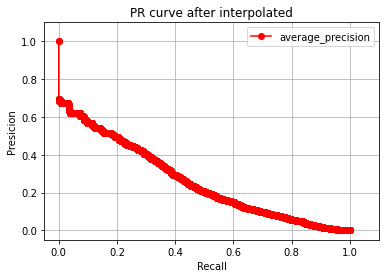

average_precision: 0.2615555615041095


In [11]:
modified_recall = np.concatenate([[1], recall, [0]])
modified_precision = np.concatenate([[0], precision, [0]])
modified_precision2 = np.maximum.accumulate(modified_precision)
average_precision = (-1)*(np.diff(modified_recall) * modified_precision2[1:]).sum()
fig, ax = plt.subplots()
ax.set_xlim(-0.05, 1.1)
ax.set_ylim(-0.05, 1.1)
ax.grid()
ax.set_title("PR curve after interpolated")
ax.set_xlabel("Recall")
ax.set_ylabel("Presicion")
ax.plot(modified_recall, modified_precision2, "bo-", label="average_precision",color='red')
ax.legend()
plt.show()
print("average_precision: "+str(auc(modified_recall, modified_precision2)))